In [1]:
import os
import sys
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
!git clone https://github.com/garythung/trashnet.git

Cloning into 'trashnet'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 45 (delta 6), reused 0 (delta 0), pack-reused 33 (from 1)
Receiving objects: 100% (45/45), 40.64 MiB | 46.29 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [33]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip ./trashnet/data/dataset-resized.zip -d ./trashnet/data

Archive:  ./trashnet/data/dataset-resized.zip
   creating: ./trashnet/data/dataset-resized/
  inflating: ./trashnet/data/dataset-resized/.DS_Store  
   creating: ./trashnet/data/__MACOSX/
   creating: ./trashnet/data/__MACOSX/dataset-resized/
  inflating: ./trashnet/data/__MACOSX/dataset-resized/._.DS_Store  
   creating: ./trashnet/data/dataset-resized/cardboard/
  inflating: ./trashnet/data/dataset-resized/cardboard/cardboard1.jpg  
  inflating: ./trashnet/data/dataset-resized/cardboard/cardboard10.jpg  
  inflating: ./trashnet/data/dataset-resized/cardboard/cardboard100.jpg  
  inflating: ./trashnet/data/dataset-resized/cardboard/cardboard101.jpg  
  inflating: ./trashnet/data/dataset-resized/cardboard/cardboard102.jpg  
  inflating: ./trashnet/data/dataset-resized/cardboard/cardboard103.jpg  
  inflating: ./trashnet/data/dataset-resized/cardboard/cardboard104.jpg  
  inflating: ./trashnet/data/dataset-resized/cardboard/cardboard105.jpg  
  inflating: ./trashnet/data/dataset-resized

In [39]:
!ls ./trashnet/data/dataset-resized/

cardboard  glass  metal  paper	plastic  trash


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

dataset_path = "data/runtime/dataset-resized"
full_dataset = datasets.ImageFolder(root=dataset_path, transform=train_transforms)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])


val_dataset.dataset.transform = val_transforms

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

In [10]:
%matplotlib inline

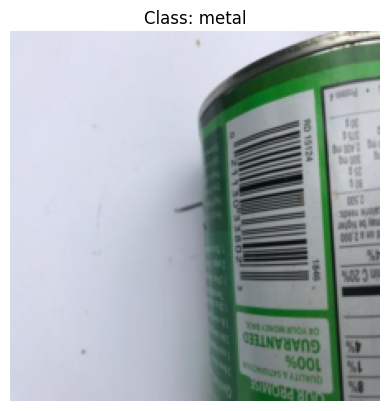

In [18]:
images, labels = next(iter(train_loader))
img = images[0]
label = labels[0]

# Undo normalization for visualization
img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)

# Convert tensor to numpy for matplotlib
img = img.permute(1, 2, 0).numpy()

# Plot the image
plt.imshow(img)
plt.title(f"Class: {full_dataset.classes[label]}")
plt.axis('off')
plt.show()

In [19]:
num_classes = len(full_dataset.classes)

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 115MB/s] 


In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [23]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")


Epoch [1/20], Loss: 0.5304, Accuracy: 0.8204
Epoch [2/20], Loss: 0.5064, Accuracy: 0.8293
Epoch [3/20], Loss: 0.4989, Accuracy: 0.8238
Epoch [4/20], Loss: 0.4618, Accuracy: 0.8427
Epoch [5/20], Loss: 0.4362, Accuracy: 0.8516
Epoch [6/20], Loss: 0.4270, Accuracy: 0.8605
Epoch [7/20], Loss: 0.4014, Accuracy: 0.8605
Epoch [8/20], Loss: 0.3963, Accuracy: 0.8580
Epoch [9/20], Loss: 0.3776, Accuracy: 0.8723
Epoch [10/20], Loss: 0.3646, Accuracy: 0.8847
Epoch [11/20], Loss: 0.3637, Accuracy: 0.8798
Epoch [12/20], Loss: 0.3522, Accuracy: 0.8897
Epoch [13/20], Loss: 0.3668, Accuracy: 0.8714
Epoch [14/20], Loss: 0.3377, Accuracy: 0.8852
Epoch [15/20], Loss: 0.3481, Accuracy: 0.8738
Epoch [16/20], Loss: 0.3314, Accuracy: 0.8902
Epoch [17/20], Loss: 0.3251, Accuracy: 0.8921
Epoch [18/20], Loss: 0.3127, Accuracy: 0.8981
Epoch [19/20], Loss: 0.3119, Accuracy: 0.9010
Epoch [20/20], Loss: 0.3001, Accuracy: 0.9040


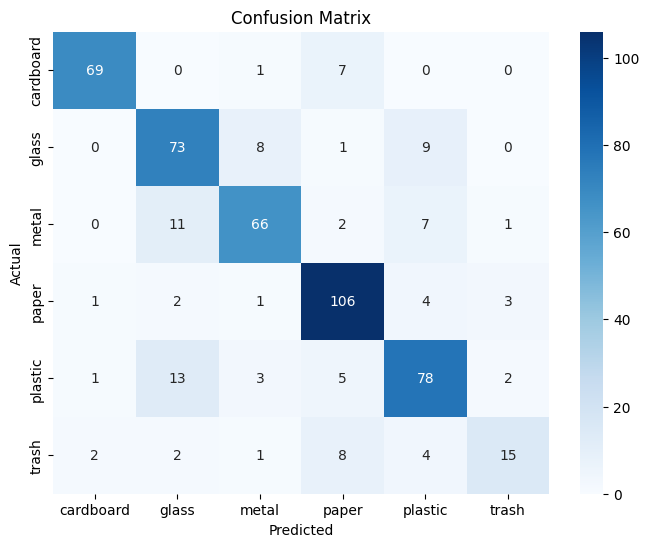

              precision    recall  f1-score   support

   cardboard       0.95      0.90      0.92        77
       glass       0.72      0.80      0.76        91
       metal       0.82      0.76      0.79        87
       paper       0.82      0.91      0.86       117
     plastic       0.76      0.76      0.76       102
       trash       0.71      0.47      0.57        32

    accuracy                           0.80       506
   macro avg       0.80      0.77      0.78       506
weighted avg       0.80      0.80      0.80       506



In [24]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=full_dataset.classes, yticklabels=full_dataset.classes, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


report = classification_report(all_labels, all_preds, target_names=full_dataset.classes)
print(report)

In [25]:
model.eval()

dummy_input = torch.randn(1, 3, 224, 224).to(device)

traced_model = torch.jit.trace(model, dummy_input)

traced_model.save("trashnet_resnet18.pt")
print("Model saved as TorchScript!")


Model saved as TorchScript!


In [46]:
!mkdir -p /content/drive/MyDrive/'Colab Notebooks'/models/
!cp trashnet_resnet18.pt /content/drive/MyDrive/'Colab Notebooks'/models/trashnet_resnet18.pt

In [48]:
!mkdir -p /content/drive/MyDrive/'Colab Notebooks'/data
!cp -r trashnet/data/dataset-resized /content/drive/MyDrive/'Colab Notebooks'/data

In [50]:
!ls /content/drive/MyDrive/'Colab Notebooks'/data/dataset-resized

cardboard  glass  metal  paper	plastic  trash
